In [76]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ast
import time
import ast

import pandas as pd

import torch 
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torchvision 
from torchvision import models, transforms
from torchvision.models import resnet18
import lightning as L 
import pytorch_lightning as pl
from torch.utils.data import random_split
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

import segmentation_models_pytorch as smp

from pathlib import Path
import os

import kagglehub

In [77]:
BATCH_SIZE = 32

### Download dataset

In [78]:
# path = Path(r"model_trening")

# path = kagglehub.dataset_download("albertozorzetto/carla-densely-annotated-driving-dataset")

# print("Path to dataset files:", path)

In [79]:
df = pd.read_csv(r"/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/model_trening/carla_dataset/classes_rgb_values.csv")

df = df[['semantic_class', 'rgb_values']]

df['rgb_values'] = df['rgb_values'].apply(ast.literal_eval)
rgb_dict = dict(zip(df['semantic_class'], df['rgb_values']))

### For CarlaDatse

In [80]:
# path_imgs_folder = Path(r"/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/project1/gazebo_train_data_generator/imgs")
# path_labels_folder = Path(r"/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/project1/gazebo_train_data_generator/masks")


path_imgs_folder = Path(r"/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/model_trening/carla_dataset/imgs")
path_labels_folder = Path(r"/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/model_trening/carla_dataset/labels")


paths2imgs = []
paths2labels = []

sunny_idxs = np.arange(0, 13).tolist()  

for img_path in path_imgs_folder.rglob("*"):
    if img_path.is_file(): 
        for idx in sunny_idxs:
            if f"_{idx}" in img_path.stem: 
                paths2imgs.append(str(img_path))
                break  

for label_path in path_labels_folder.rglob("*"):
    if label_path.is_file():
        for idx in sunny_idxs:
            if f"_{idx}" in label_path.stem:
                paths2labels.append(str(label_path))
                break

print(len(paths2imgs))
print(len(paths2labels))

10767
10767


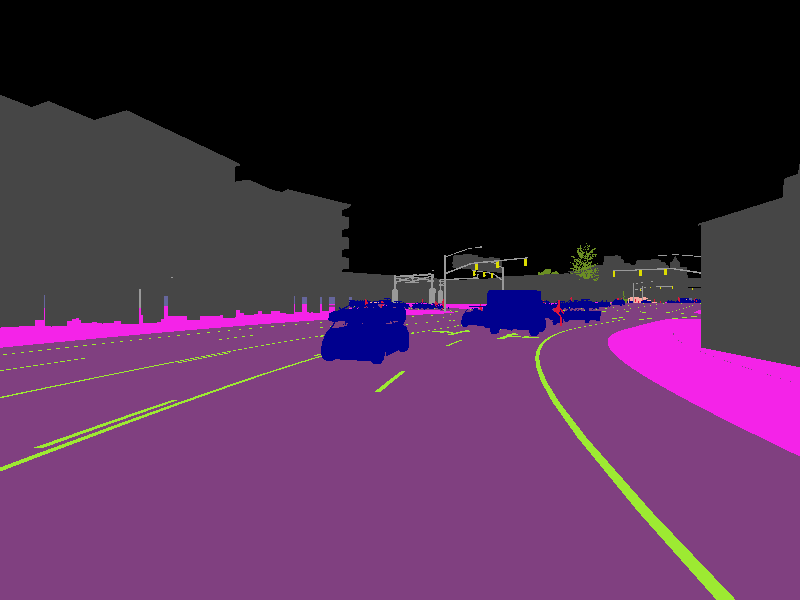

In [81]:
Image.open(paths2labels[0])

### For Custom Dataset

In [82]:
path_imgs_folder = Path(r"/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/project1/gazebo_train_data_generator/imgs")
path_labels_folder = Path(r"/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/project1/gazebo_train_data_generator/masks")

paths2imgs = []
paths2labels = []

for path in os.listdir(path_imgs_folder):
    if path.endswith('.jpg') or path.endswith('.png'): 
        paths2imgs.append(os.path.join(path_imgs_folder, path))

for path in os.listdir(path_labels_folder):
    if path.endswith('.npy'): 
        paths2labels.append(os.path.join(path_labels_folder, path))
        
paths2imgs.sort()
paths2labels.sort()

print(len(paths2imgs))
print(len(paths2labels))

832
832


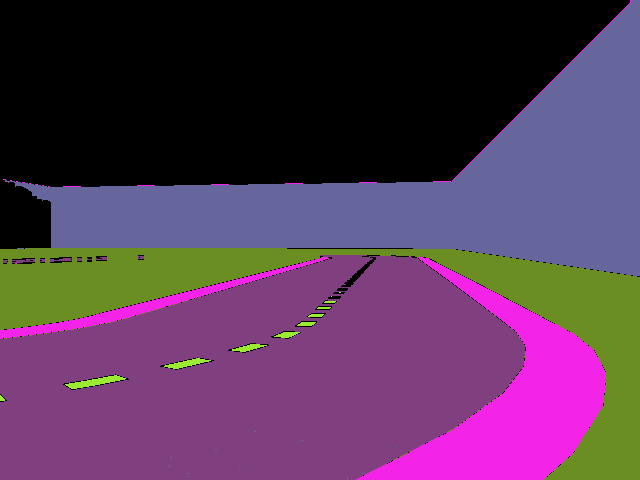

In [83]:
Image.fromarray(np.load(paths2labels[0]))

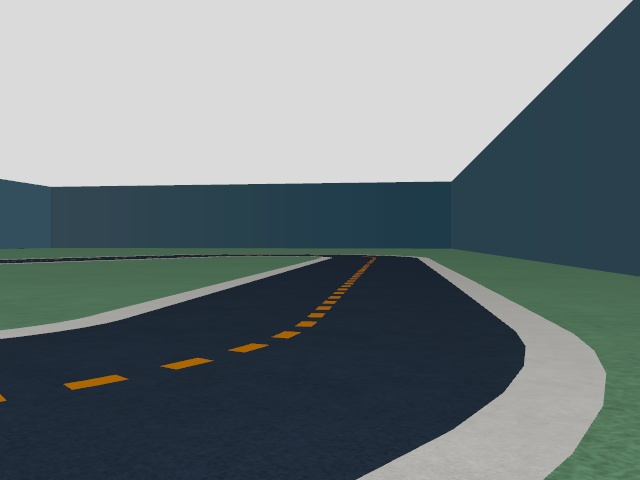

In [84]:
Image.open(paths2imgs[0])

In [85]:
df = pd.read_csv("/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/model_trening/carla_dataset/classes_rgb_values.csv")
df = df[['semantic_class', 'rgb_values']]

df['rgb_values'] = df['rgb_values'].apply(ast.literal_eval)

dict_ = dict(zip(df['semantic_class'], df['rgb_values']))

In [86]:
class CarlaDataset(Dataset):
	def __init__(self, imgs_paths: list, labels_paths: list, masks_name: list, dict_: dict, transform=None):
		self.imgs_paths = imgs_paths
		self.labels_paths = labels_paths
		self.masks_name = masks_name
		self.transform = transform

		self.dict_ = {k: ast.literal_eval(v) if isinstance(v, str) else v for k, v in dict_.items()}

	def __len__(self):
		return len(self.imgs_paths)

	def __getitem__(self, idx):
		img_path = self.imgs_paths[idx]
		label_path = self.labels_paths[idx]
		img, mask = self.open_paths(img_path, label_path)
		
		if self.transform:
			img = self.transform(img)  
		
		mask = cv2.resize(mask, (img.shape[2], img.shape[1]), interpolation=cv2.INTER_NEAREST)
		
		num_classes = len(self.masks_name) + 1
		mask_one_hot = np.zeros((num_classes, mask.shape[0], mask.shape[1]), dtype=np.float32)
		
		for i in range(num_classes):
			mask_one_hot[i] = (mask == i).astype(np.float32)
		
		mask_one_hot = torch.from_numpy(mask_one_hot)  
		
		return img, mask_one_hot



	def open_paths(self, img_path, label_path):
		img = Image.open(img_path).convert('RGB')
		mask = Image.fromarray(np.load(label_path)).convert('RGB')
		mask_np = np.array(mask)
		mask_indexed = np.zeros(mask_np.shape[:2], dtype=np.uint8)

		for i, name in enumerate(self.masks_name, start=1):
			if name not in self.dict_:
				continue
			rgb = np.array(self.dict_[name])
			match = np.all(mask_np == rgb, axis=-1)
			mask_indexed[match] = i

		return img, mask_indexed

In [87]:
class CarlaDataModule(pl.LightningDataModule):
    def __init__(self, imgs_paths, labels_paths, masks_name, dict_, batch_size=8, num_workers=4, transform=None, val_split=0.2):
        super().__init__()
        self.imgs_paths = imgs_paths
        self.labels_paths = labels_paths
        self.masks_name = masks_name
        self.dict_ = dict_
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform
        self.val_split = val_split
        
        self.train_dataset = None
        self.val_dataset = None

    def setup(self, stage=None):
        full_dataset = CarlaDataset(
            self.imgs_paths,
            self.labels_paths,
            self.masks_name,
            self.dict_,
            transform=self.transform
        )

        val_size = int(len(full_dataset) * self.val_split)
        train_size = len(full_dataset) - val_size
        self.train_dataset, self.val_dataset = random_split(full_dataset, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return self.val_dataloader()

In [88]:
dict_

{'Traffic Sign': [220, 220, 0],
 'Building': [70, 70, 70],
 'Fence': [190, 153, 153],
 'Other': [250, 170, 160],
 'Pedestrian': [220, 20, 60],
 'Pole': [153, 153, 153],
 'Road Line': [157, 234, 50],
 'Road': [128, 64, 128],
 'Sidewalk': [244, 35, 232],
 'Vegetation': [107, 142, 35],
 'Car': [0, 0, 142],
 'Wall': [102, 102, 156],
 'Unlabeled': [0, 0, 0]}

In [89]:
masks_name = ['Building', 'Road Line', 'Road', 'Sidewalk', 'Car', 'Vegetation', 'Wall']

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data_module = CarlaDataModule(
	imgs_paths=paths2imgs,
	labels_paths=paths2labels,
	masks_name=masks_name,
	dict_=dict_,
	batch_size=BATCH_SIZE,
	transform=transform,
)

data_module.setup()

In [90]:
batch = next(iter(data_module.train_dataloader()))
imgs, masks = batch

print(imgs.shape, masks.shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 8, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.0648367].


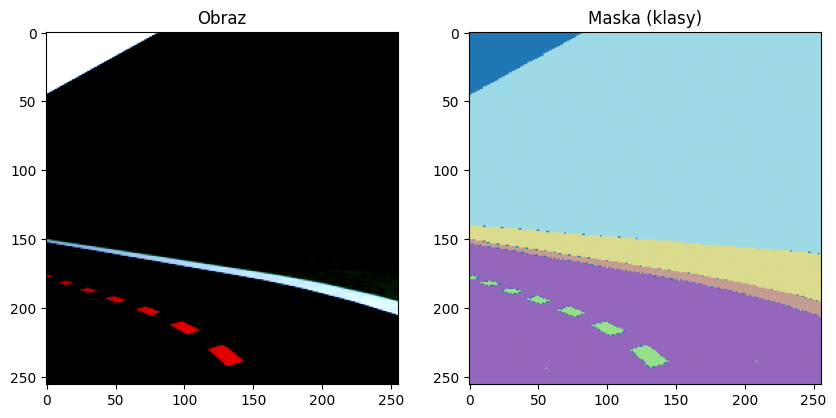

In [91]:
img = imgs[1]
mask = masks[1]

img_np = img.permute(1, 2, 0).cpu().numpy()

mask_np = mask.cpu().numpy()
mask_classes = mask_np.argmax(axis=0) 

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_np)
axs[0].set_title('Obraz')
axs[1].imshow(mask_classes, cmap='tab20')
axs[1].set_title('Maska (klasy)')
plt.show()

In [92]:
masks[0].shape

torch.Size([8, 256, 256])

In [93]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision.models import resnet18

# class DoubleConv2D(nn.Module):
#     def __init__(self, in_ch: int, out_ch: int, dropout: float = 0.0):
#         super().__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(inplace=True),
#             nn.Dropout2d(dropout),
#             nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(inplace=True),
#             nn.Dropout2d(dropout)
#         )
    
#     def forward(self, x):
#         return self.block(x)

# class ResNetEncoder(nn.Module):
#     def __init__(self, pretrained: bool = True):
#         super().__init__()
#         resnet = resnet18(weights="IMAGENET1K_V1" if pretrained else None)
#         self.layer0 = nn.Sequential(
#             resnet.conv1,
#             resnet.bn1,
#             resnet.relu,
#             resnet.maxpool
#         )
#         self.layer1 = resnet.layer1
#         self.layer2 = resnet.layer2
#         self.layer3 = resnet.layer3
#         self.layer4 = resnet.layer4

#     def forward(self, x):
#         x0 = self.layer0(x)  # 1/4
#         x1 = self.layer1(x0) # 1/4
#         x2 = self.layer2(x1) # 1/8
#         x3 = self.layer3(x2) # 1/16
#         x4 = self.layer4(x3) # 1/32
#         return [x4, x3, x2, x1, x0]

# class ResNetDecoder(nn.Module):
#     def __init__(self, dropout=0.0):
#         super().__init__()
#         # in_ch z upconv, skip_ch z enkodera, out_ch po double conv
#         channels = [
#             (512, 256, 256),  # x4_up + x3
#             (256, 128, 128),  # x3_up + x2
#             (128, 64, 64),    # x2_up + x1
#             (64, 64, 64)      # x1_up + x0  <- ostatni krok nie zmienia HxW
#         ]

#         self.upconvs = nn.ModuleList([
#             nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
#             for in_ch, skip_ch, out_ch in channels
#         ])

#         self.double_convs = nn.ModuleList([
#             DoubleConv2D(out_ch + skip_ch, out_ch, dropout=dropout)
#             for in_ch, skip_ch, out_ch in channels
#         ])

#         self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

#     def forward(self, features):
#         x = features[0]  # bottleneck
#         skips = features[1:]  # x3, x2, x1, x0

#         for i in range(len(self.upconvs)):
#             x = self.upconvs[i](x)
#             skip = skips[i]
#             # teraz rozmiary idealnie pasują
#             assert x.shape[-2:] == skip.shape[-2:], f"Shape mismatch at level {i}: {x.shape} vs {skip.shape}"
#             x = torch.cat([x, skip], dim=1)
#             x = self.double_convs[i](x)

#         out = self.out_conv(x)
#         return out

# class ResNetUNet(nn.Module):
#     def __init__(self, dropout=0.1):
#         super().__init__()
#         self.encoder = ResNetEncoder(pretrained=True)
#         self.decoder = ResNetDecoder(dropout=dropout)

#     def forward(self, x):
#         features = self.encoder(x)
#         out = self.decoder(features)
#         return out


In [94]:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# import torch.nn.functional as F

# class UNetResNet18(nn.Module):
#     def __init__(self, n_classes):
#         super(UNetResNet18, self).__init__()
        
#         resnet = models.resnet18(pretrained=True)
        
#         self.encoder0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)  # 64, /2
#         self.encoder1 = nn.Sequential(resnet.maxpool, resnet.layer1)          # 64, /4
#         self.encoder2 = resnet.layer2                                         # 128, /8
#         self.encoder3 = resnet.layer3                                         # 256, /16
#         self.encoder4 = resnet.layer4                                         # 512, /32

#         # Bottleneck
#         self.bottleneck = nn.Conv2d(512, 512, kernel_size=3, padding=1)

#         self.up4 = self.up_block(512, 256)
#         self.up3 = self.up_block(256, 128)
#         self.up2 = self.up_block(128, 64)
#         self.up1 = self.up_block(64, 64)
#         self.up0 = self.up_block(64, 64)

#         self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
    
#     def up_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )
    
#     def forward(self, x):
#         e0 = self.encoder0(x)
#         e1 = self.encoder1(e0)
#         e2 = self.encoder2(e1)
#         e3 = self.encoder3(e2)
#         e4 = self.encoder4(e3)

#         b = self.bottleneck(e4)

#         d4 = self.up4(b) + e3
#         d3 = self.up3(d4) + e2
#         d2 = self.up2(d3) + e1
#         d1 = self.up1(d2) + e0
#         d0 = self.up0(d1)

#         out = self.final_conv(d0)
#         return out.unsqueeze(1)

# class LitUNet(pl.LightningModule):
#     def __init__(self, n_classes=1, lr=1e-3):
#         super().__init__()
#         self.model = UNetResNet18(n_classes=n_classes)
#         self.lr = lr
#         self.loss_fn = nn.CrossEntropyLoss()  # dla maski z etykietami 0..n_classes-1
    
#     def forward(self, x):
#         return self.model(x)
    
#     def training_step(self, batch, batch_idx):
#         x, y = batch  # x: [B,3,H,W], y: [B,H,W] z wartościami 0..n_classes-1
#         logits = self(x)  # [B, n_classes, H, W]
#         loss = self.loss_fn(logits, y)
#         self.log("train_loss", loss)
#         return loss
    
#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         logits = self(x)
#         loss = self.loss_fn(logits, y)
#         self.log("val_loss", loss)
#         return loss
    
#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=self.lr)

In [95]:
model = smp.Unet(
            encoder_name="resnet18",
            encoder_weights="imagenet",
            in_channels=3,
            classes=len(masks_name)
        )

out = model(imgs)

out.shape

torch.Size([32, 7, 256, 256])

In [96]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

class DiceMetric:
    """Manual implementation of Dice score for multi-class segmentation"""
    def __init__(self, num_classes, epsilon=1e-6):
        self.num_classes = num_classes
        self.epsilon = epsilon

    def __call__(self, preds, targets):
        """
        preds: [B, H, W] int64 (after argmax)
        targets: [B, H, W] int64
        """
        dice = 0.0
        for cls in range(self.num_classes):
            pred_cls = (preds == cls).float()
            target_cls = (targets == cls).float()
            intersection = (pred_cls * target_cls).sum()
            union = pred_cls.sum() + target_cls.sum()
            dice_cls = (2 * intersection + self.epsilon) / (union + self.epsilon)
            dice += dice_cls
        return dice / self.num_classes  # average over classes

class LitUNet(pl.LightningModule):
    def __init__(self, n_classes=4, lr=1e-3):  
        super().__init__()
        self.model = smp.Unet(
            encoder_name="resnet18",
            encoder_weights="imagenet",
            in_channels=3,
            classes=n_classes
        )
        self.lr = lr
        self.loss_fn = nn.CrossEntropyLoss()  
        self.dice_metric = DiceMetric(num_classes=n_classes)

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)  
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.argmax(dim=1) if y.ndim==4 else y)  # CrossEntropy wymaga [B,H,W]
        
        preds = torch.argmax(logits, dim=1)
        y_labels = y.argmax(dim=1) if y.ndim==4 else y  # przekształcenie one-hot do etykiet
        dice_score = self.dice_metric(preds, y_labels)
        
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_dice", dice_score, on_step=False, on_epoch=True)
        return loss


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [98]:
model = LitUNet.load_from_checkpoint(
    r'/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/model_trening/cheakpoint/best-unet-epoch=06-val_dice=0.9587.ckpt',
    n_classes=8  
)


early = EarlyStopping(
    monitor='val_dice',
    mode="max",
    patience=5, 
    verbose=True
)

ckpt = ModelCheckpoint(
    monitor='val_dice',
    mode='max',
    filename='/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/model_trening/best-unet-{epoch:02d}-{val_dice:.4f}',
    save_top_k=1
)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    callbacks=[early, ckpt],
    precision=16  
)

trainer.fit(model, datamodule=data_module)

/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/patryk/Desktop/venv

/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|█████████████████████████| 21/21 [00:18<00:00,  1.14it/s, v_num=0]

Metric val_dice improved. New best score: 0.760


Epoch 1: 100%|█████████████████████████| 21/21 [00:18<00:00,  1.15it/s, v_num=0]

Metric val_dice improved by 0.191 >= min_delta = 0.0. New best score: 0.951


Epoch 2: 100%|█████████████████████████| 21/21 [00:18<00:00,  1.12it/s, v_num=0]

Metric val_dice improved by 0.006 >= min_delta = 0.0. New best score: 0.956


Epoch 3: 100%|█████████████████████████| 21/21 [00:19<00:00,  1.09it/s, v_num=0]

Metric val_dice improved by 0.001 >= min_delta = 0.0. New best score: 0.958


Epoch 4: 100%|█████████████████████████| 21/21 [00:18<00:00,  1.15it/s, v_num=0]

Metric val_dice improved by 0.025 >= min_delta = 0.0. New best score: 0.983


Epoch 5: 100%|█████████████████████████| 21/21 [00:20<00:00,  1.04it/s, v_num=0]

Metric val_dice improved by 0.001 >= min_delta = 0.0. New best score: 0.984


Epoch 10:  19%|████▊                    | 4/21 [00:03<00:15,  1.11it/s, v_num=0]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
masks.shape

torch.Size([32, 8, 256, 256])

In [99]:

# checkpoint_path = "/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/model_trening/best-unet-epoch=06-val_dice=0.9587.ckpt"
# model = LitUNet.load_from_checkpoint(checkpoint_path, n_classes=8)
model.eval()
model.cuda()  



transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

model.eval()
model.cuda()

num_images = 100
start_time = time.time()

for i in range(num_images):
    input_tensor = transform(Image.open(paths2imgs[i])).unsqueeze(0).cuda()  

    with torch.no_grad():
        output = model(input_tensor)  
        predicted_mask = torch.argmax(output, dim=1)

end_time = time.time()

total_time = end_time - start_time
fps = num_images / total_time

print(f"Czas dla {num_images} obrazów: {total_time:.2f} s")
print(f"Średni FPS: {fps:.2f}")

Czas dla 100 obrazów: 0.90 s
Średni FPS: 110.72


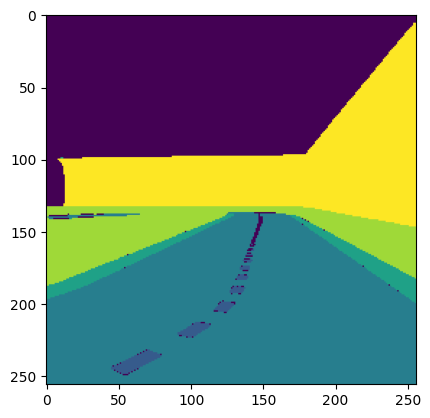

In [100]:
input_tensor = transform(Image.open(r"/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/model_trening/test_imgs/image.png").convert("RGB")).unsqueeze(0).cuda()  

with torch.no_grad():
    output = model(input_tensor)  
    predicted_mask = torch.argmax(output, dim=1)

plt.imshow(predicted_mask.cpu().numpy().squeeze(0))

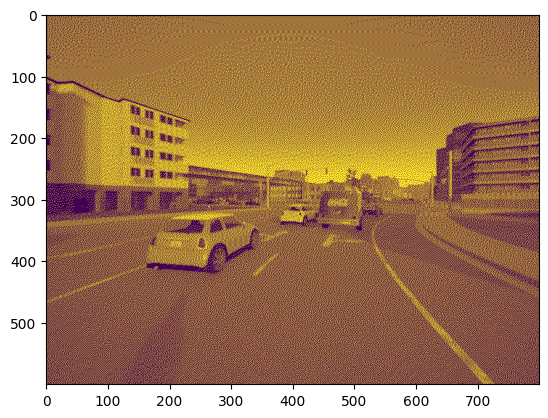

In [ ]:
plt.imshow(np.array(Image.open(paths2imgs[2]).convert("1")))

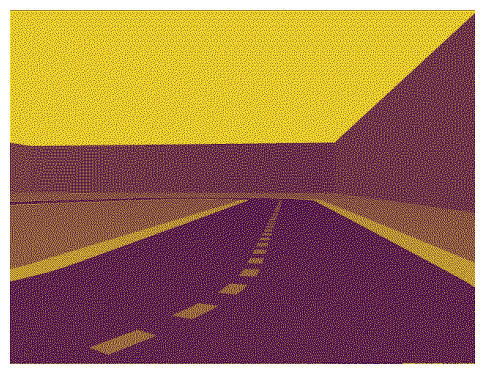

In [ ]:
img_hsv = Image.open("/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/model_trening/test_imgs/image.png").convert("1")

img_hsv_np = np.array(img_hsv)

plt.figure(figsize=(6,6))
plt.imshow(img_hsv_np)
plt.axis('off')
plt.show()